## Hyperparameter tuning using RandomSearchCV

In [53]:
import numpy as np # linear algebra

from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.activations import relu, elu
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from keras import backend as K
from tensorflow.keras import Model, Sequential, models, layers

from talos.model.normalizers import lr_normalizer
import talos as ta
import wrangle as wr
from talos.model.early_stopper import early_stopper

np.random.seed(6)
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

img_rows, img_cols = 28, 28
num_classes = 10

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

min_int = np.random.randint(2,4)
max_int = np.random.randint(5,6)

filters = []

for rep in range(min_int, max_int):
    layer = np.random.randint(32, 84)
    filters.append(layer)

filters = sorted(filters)

In [54]:
p = {
    'filters': [64, 128],
    'num_conv_layers': [2,3,4],
    'kernel_size': [2,3],
    'neurons': [64, 128, 256],
    'pool_size': [2,3],
    'batch_size': [40,50],
    'epochs': [1],
    'dropout': (0, 0.5, 0.1),
    'kernel_initializer': ['uniform','normal'],
    'optimizer': [SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam],
    'lr': (0.1, 0.5, 0.1),
    'losses': [categorical_crossentropy],
    'activation': [relu, elu],
    'last_activation': ['softmax']
}

In [55]:
def cnn_model(x_train, y_train, x_val, y_val, params, num_classes = num_classes, input_shape = input_shape):
    model = Sequential()
    
    for index in range(0, params['num_conv_layers']):
        if index == 0:
            model.add(layers.Conv2D(params['filters'], params['kernel_size'], input_shape = input_shape, activation = params['activation']))
        else:
            model.add(layers.Conv2D(params['filters'], params['kernel_size'], activation = params['activation']))

    model.add(layers.MaxPooling2D(pool_size=params['pool_size']))
    
    if params['dropout']:
        model.add(layers.Dropout(params['dropout']))

    model.add(layers.Flatten())
    model.add(layers.Dense(params['neurons'], activation=params['activation']))
    
    if params['dropout']:
        model.add(layers.Dropout(params['dropout']))
    
    model.add(layers.Dense(num_classes, activation = params['last_activation']))

    model.compile(loss=params['losses'],
              optimizer=params['optimizer'](lr=lr_normalizer(params['lr'], params['optimizer'])),
              metrics=['accuracy'])

    callbacks = [EarlyStopping(monitor = 'val_loss', patience = 1)]

    out = model.fit(x_train, y_train,
                    batch_size=params['batch_size'],
                    epochs=params['epochs'],
                    verbose=1,
                    callbacks=callbacks,
                    validation_data=(x_test, y_test))

    return out, model

t = ta.Scan(x = x_train,
            y = y_train,
            x_val = x_test,
            y_val = y_test,
            model = cnn_model,
            params = p,
            dataset_name = "MNIST",
            experiment_no="1",
            grid_downsample = 0.0005)






  0%|          | 0/2 [00:00<?, ?it/s]W0722 11:49:25.984395 4505560512 deprecation.py:506] From /Users/ebolotin/Dropbox/techdev/env/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/adagrad.py:105: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 225s 4ms/sample - loss: 124.3343 - acc: 0.7380 - val_loss: 0.3762 - val_acc: 0.8815







 50%|█████     | 1/2 [03:45<03:45, 225.18s/it]

Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 169s 3ms/sample - loss: 239.6457 - acc: 0.1119 - val_loss: 2.3010 - val_acc: 0.1135







100%|██████████| 2/2 [06:34<00:00, 208.55s/it]

In [40]:
t.data['val_acc'].max()

0.9852

In [41]:
# return best model
t.data.loc[t.data['val_acc'] == t.data['val_acc'].max(),:]

# # accessing epoch entropy values for each round
# t.peak_epochs_df

# # access the summary details
# t.details

,round_epochs,loss,acc,val_loss,val_acc,filters,num_conv_layers,kernel_size,neurons,pool_size,batch_size,epochs,dropout,kernel_initializer,optimizer,losses,activation,last_activation
2,1,0.283889,0.961333,0.047872,0.9852,128,2,3,128,3,50,1,0.0,uniform,Nadam,<function categorical_crossentropy at 0x121fd5...,<function relu at 0x122854c20>,softmax


In [14]:
# use Scan object as input
r = ta.Reporting(t)

# use filename as input
r = ta.Reporting('MNIST_1.csv')

In [16]:
# access the dataframe with the results
r.data.head()

,round_epochs,loss,acc,val_loss,val_acc,filters,num_conv_layers,kernel_size,neurons,pool_size,batch_size,epochs,dropout,kernel_initializer,optimizer,losses,activation,last_activation
0,1,NaN,0.098833,NaN,0.0980,32,2,3,128,2,40,1,0.0,normal,SGD,<function categorical_crossentropy at 0x121fd5...,<function elu at 0x1211254d0>,softmax
1,1,0.272885,0.951033,0.082823,0.9746,64,2,3,64,2,40,1,0.0,uniform,Adam,<function categorical_crossentropy at 0x121fd5...,<function elu at 0x1211254d0>,softmax
2,1,0.283889,0.961333,0.047872,0.9852,128,2,3,128,3,50,1,0.0,uniform,Nadam,<function categorical_crossentropy at 0x121fd5...,<function relu at 0x122854c20>,softmax
3,1,0.263644,0.947650,0.084276,0.9767,32,2,3,64,3,40,1,0.0,uniform,Adam,<function categorical_crossentropy at 0x121fd5...,<function elu at 0x1211254d0>,softmax
4,1,0.313566,0.954567,0.067282,0.9774,64,2,3,96,3,50,1,0.0,normal,Nadam,<function categorical_crossentropy at 0x121fd5...,<function elu at 0x1211254d0>,softmax


In [22]:
# get the number of rounds in the Scan
r.rounds()

# get the highest result ('val_acc' by default)
r.high()

# # get the highest result for any metric
r.high('acc')

# get the round with the best result
r.rounds2high()

# get the best paramaters
r.best_params()

# get correlation for hyperparameters against a metric
r.correlate('val_loss')

filters           -0.918469
num_conv_layers         NaN
kernel_size       -0.292933
neurons           -0.994745
pool_size         -0.543421
batch_size        -0.739758
epochs                  NaN
dropout                 NaN
Name: val_loss, dtype: float64

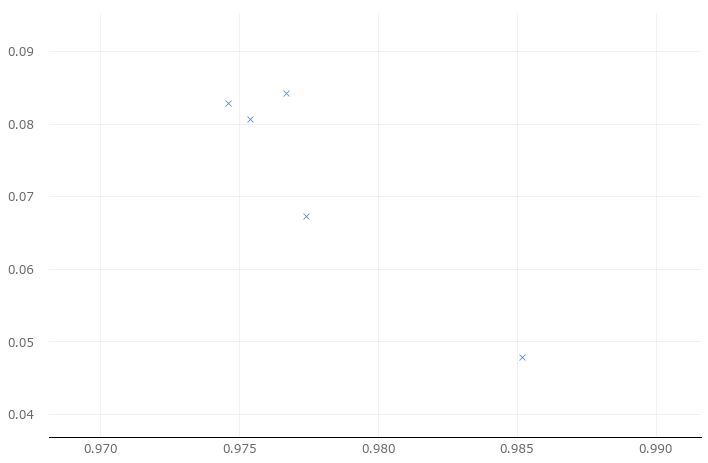

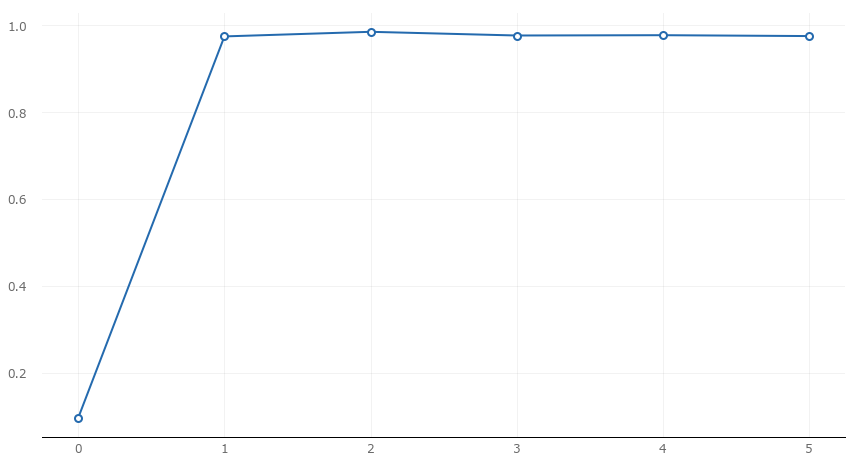

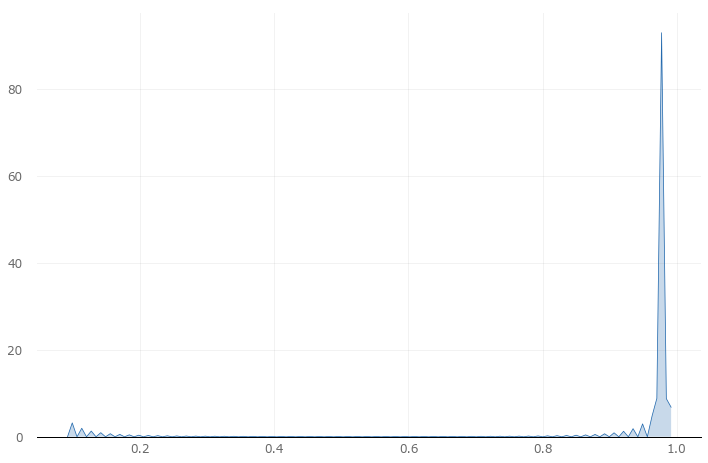

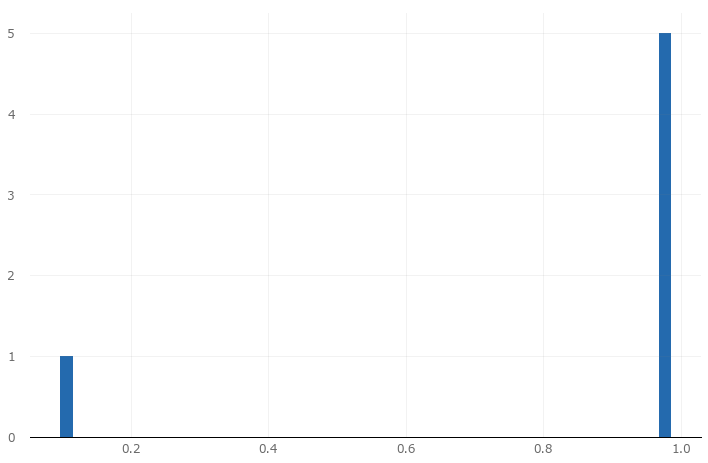

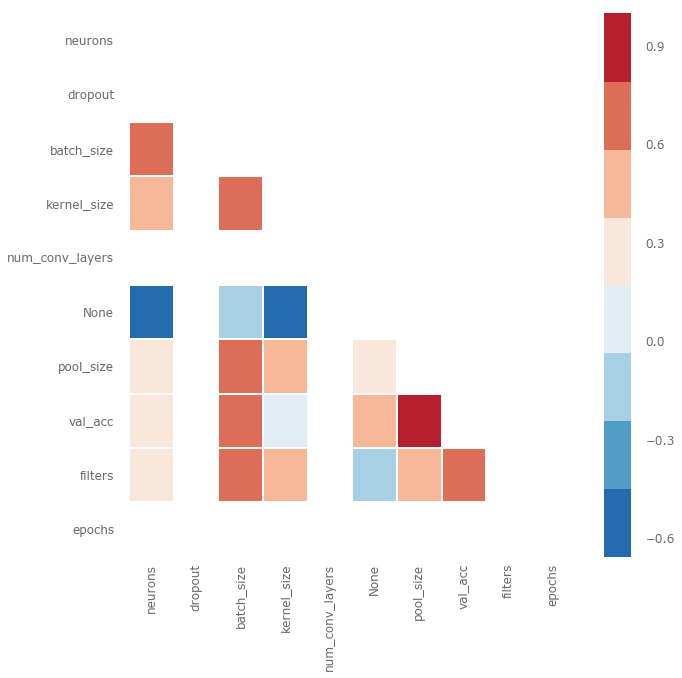

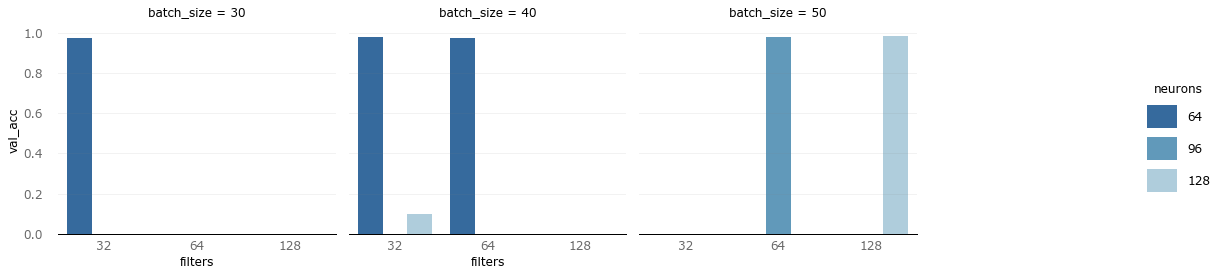

In [29]:
# a regression plot for two dimensions 
r.plot_regs()

# line plot
r.plot_line()

# up to two dimensional kernel density estimator
r.plot_kde('val_acc')

# a simple histogram
r.plot_hist(bins=50)

# heatmap correlation
r.plot_corr()

# a four dimensional bar grid
r.plot_bars('filters', 'val_acc', 'neurons', 'batch_size')

### Evaluate model with 10 fold cv

In [ ]:
e = ta.Evaluate(h)
e.evaluate(x, y, folds=10, average='macro')